In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/six-machine-oscillations/PWB1 VM 2500.csv


In [3]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-pjdsp6er
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-pjdsp6er
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit afd9cfd062b60ca1ba8d7c9daef7dc820489db0a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos: filename=chronos-1.2.0-py3-none-any.whl size=13875 sha256=39c7f7f941e8caba9bf5ed41077b41e1d8570b15cfececffb179c625b9f2f0e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ow4wx3rh/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

df = pd.read_csv("/kaggle/input/six-machine-oscillations/PWB1 VM 2500.csv")


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
start_time = '2023-01-01 00:00:00'
date_range = pd.date_range(start=start_time, periods=len(df), freq='S')

# Add the DateTime column to the DataFrame
df['DateTime'] = date_range

# Reorder columns if necessary
df = df[['DateTime', 'V2']]

/tmp/ipykernel_34/4079954001.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  date_range = pd.date_range(start=start_time, periods=len(df), freq='S')


In [16]:
df.head()

,DateTime,V2
0,2023-01-01 00:00:00,-29
1,2023-01-01 00:00:01,17
2,2023-01-01 00:00:02,-6
3,2023-01-01 00:00:03,-9
4,2023-01-01 00:00:04,15


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='DateTime', ylabel='V2'>

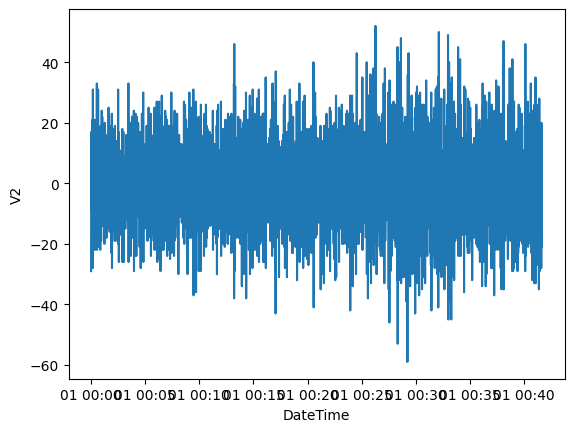

In [17]:
import seaborn as sns
sns.lineplot(data=df, x='DateTime', y = 'V2')

In [18]:
context = torch.tensor(df["V2"])
prediction_length = 64
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df.head(100)), len(df.head(100)) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


2024-06-25 20:39:05.806690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 20:39:05.806790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 20:39:05.943541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [19]:
forecast[0]

tensor([[ 4.9542e+00,  6.9941e+00,  4.9542e+00,  ..., -1.3405e+01,
          1.3017e+01,  9.0341e+00],
        [ 4.9542e+00,  7.9655e+00, -3.0114e+00,  ...,  2.0400e+00,
          2.0982e+01, -3.9828e+00],
        [-2.1371e+00,  1.3697e+01,  3.9828e+00,  ...,  1.3017e+01,
          2.0400e+00, -3.9828e+00],
        ...,
        [-1.5251e+01,  2.0400e+00,  9.0341e+00,  ..., -7.0913e+00,
          1.0005e+01,  6.9941e+00],
        [ 1.0005e+01,  9.0341e+00, -9.0341e+00,  ...,  9.0341e+00,
          6.0227e+00,  7.9655e+00],
        [ 9.0341e+00, -2.0400e+00,  9.0341e+00,  ..., -2.6228e+00,
          9.0341e+00,  1.8510e-07]])

<Figure size 1000x700 with 0 Axes>

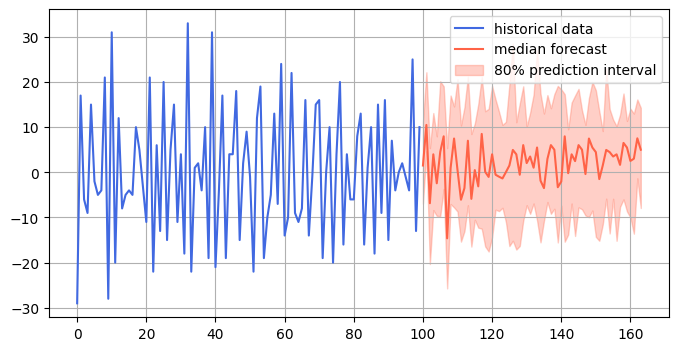

In [21]:
plt.figure(figsize=(10,7))
# visualize the results
plt.figure(figsize=(8, 4))
plt.plot(df['V2'].head(100), color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show();

In [ ]:
low